In [95]:
from tqdm.auto import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy
from aquarel import load_theme

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

In [2]:
# Read configuration file
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==4:
    target='DELV24'
elif int(config_set['target_lag'])==8:
    target='DELV48'
seeds = np.arange(100,130,1)

In [4]:
for seed in seeds:
    #---------------------------------------------------------------------------------------------------------
    # Create Pandas DataFrame
    #---------------------------------------------------------------------------------------------------------
    # Process the filted TC list in the config file
    TC_tofilt_list = ast.literal_eval(config_set['TCfilt'])
    # Get the names of the remaining TCs
    filt_TClist = read_vars.remove_storms(trackpath=config_set['track_path'],
                                          basinID=config_set['basin'],
                                          yearmin=int(config_set['start_year']),
                                          yearmax=int(config_set['end_year']),
                                          remove_set=TC_tofilt_list
                                         )
    # Read saved SHIPS csvs
    storeSHIPS = read_vars.read_SHIPS_csv(startyear=int(config_set['start_year']),
                                          endyear=int(config_set['end_year']),
                                          vars_path=config_set['vars_path'],
                                          filted_TCnames=filt_TClist,suffixlist=['newships_dev_POT']
                                         )
    # Read selected variables from the pandas dfs
    SHIPS_df = read_vars.create_SHIPS_df(startyear=int(config_set['start_year']),
                                         endyear=int(config_set['end_year']),
                                         SHIPSdict=storeSHIPS,
                                         wantvarnames=config_set['SHIPSops_varname'],
                                         targetname=target,
                                         filted_TCnames=filt_TClist,
                                         lagnum=int(config_set['target_lag']),
                                         withshift='No',
                                        )
    # Add derived variables stored separately
    store_dfstorms_ships = read_vars.add_derive_df(startyear=int(config_set['start_year']),
                                                   endyear=int(config_set['end_year']),
                                                   SHIPSdict=SHIPS_df,
                                                   addfilepath='/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/SHIPS/ships_pkl/all_storms_ships23vars_obswmax.pkl',
                                                   addvarname=['pc20'],
                                                   filted_TCnames=filt_TClist,
                                                   lagnum=int(config_set['target_lag']),
                                                   withshift='No',
                                                  )
    
    var_names=store_dfstorms_ships[2001]['ALLISON'].columns.values.tolist()
    
    TC_fulllist = {}
    for year in np.linspace(int(config_set['start_year']),int(config_set['end_year']),int(config_set['end_year'])-int(config_set['start_year'])+1):
        temp = store_dfstorms_ships[year]
        for ind,name in enumerate(temp.keys()):
            TC_fulllist[str(int(year))+'_'+name] = temp[name]
            
    #---------------------------------------------------------------------------------------------------------
    # ML-ready dataset
    #---------------------------------------------------------------------------------------------------------
    # Split data with a 0.15 test, 0.15 valid split
    datastorer = proc_dataset.splitdata_handler(df=TC_fulllist,
                                                method='year',
                                                seed=seed,
                                                config=config_set,
                                                testyears=[2020,2021]
                                               )
    # Remove empty storms in the data
    traincleaned = {key: datastorer['train'][key] for ind,key in enumerate(datastorer['train'].keys()) if datastorer['train'][key].shape[0]>0}
    validcleaned = {key: datastorer['valid'][key] for ind,key in enumerate(datastorer['valid'].keys()) if datastorer['valid'][key].shape[0]>0}
    testcleaned = {key: datastorer['test'][key] for ind,key in enumerate(datastorer['test'].keys()) if datastorer['test'][key].shape[0]>0}
    
    # Replace original training data with the cleaned version
    datastorer_n = deepcopy(datastorer)
    
    # Replace
    datastorer_n['train'] = traincleaned
    datastorer_n['valid'] = validcleaned
    datastorer_n['test'] = testcleaned

    # Get smoothed MSLP data and argmin values
    smoothed_MSLP, MSLP_argmin = proc_dataset.proc_data(df=datastorer_n,
                                                    seed=seed).smooth_and_minindices(varname='MSLP',sigma=3)
    # Aligned the inputs with the minimum SLP data
    aligned_train = proc_dataset.proc_data(df=datastorer_n,seed=seed).do_data_align(datastorer_n['train'],MSLP_argmin['train'],var_names)
    aligned_valid = proc_dataset.proc_data(df=datastorer_n,seed=seed).do_data_align(datastorer_n['valid'],MSLP_argmin['valid'],var_names)
    aligned_test = proc_dataset.proc_data(df=datastorer_n,seed=seed).do_data_align(datastorer_n['test'],MSLP_argmin['test'],var_names)
    
    # Combine different TCs into a long dataset
    X,y,size = proc_dataset.df_proc_separate(aligned_train,aligned_valid,aligned_test,target)

    # Find the mean and std of the training set for normalization
    trainmean,trainstd = X['train'].dropna().mean(axis=0),X['train'].dropna().std(axis=0)

    # Data normalization
    Xnorml = proc_dataset.normalized_TCs_handler(train=aligned_train,
                                                 valid=aligned_valid,
                                                 test=aligned_test,
                                                 trainmean=trainmean,
                                                 trainstd=trainstd,
                                                 dropcol=[target],
                                                 target=target
                                                )
    var_names = Xnorml['train'][list(Xnorml['train'].keys())[0]].columns

    #---------------------------------------------------------------------------------------------------------
    # Causal
    #---------------------------------------------------------------------------------------------------------
    onlyships_lag = causal_settings.link_onlyships(numvar=aligned_train[list(aligned_train.keys())[0]].shape[1],
                                                   lag=int(config_set['target_lag']),
                                                   target_ind=[0]
                                                  )

    results = []
    for pc_alpha in tqdm([0.0001, 0.00015 ,0.001,0.0015,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,
                          0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.86,0.88,0.9]):
        Xnorml_c = {'train': {ind: np.asarray(Xnorml['train'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['train'].keys())},
                    'valid': {ind: np.asarray(Xnorml['valid'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['valid'].keys())},
                    'test': {ind: np.asarray(Xnorml['test'][key].replace(np.nan,-999.0)) for ind,key in enumerate(Xnorml['test'].keys())}
                   }
        result = train_PC1.Pipeline(Xnorml_c['train'],
                                    pc_alpha,
                                    pc_type='run_pcstable',
                                    tau_min0=int(config_set['tau_min']),
                                    tau_max0=int(config_set['tau_max']),
                                    var_name=var_names,
                                    link_assumptions=onlyships_lag).run_tigramite()
        del Xnorml_c
        gc.collect()
        results.append(result)
    
    savetos = {'dataframes':Xnorml,'PC1_results':results,'var_names':var_names}
    with open('../2024_causalML_results/results/'+str(int(config_set['target_lag']))+'_tmin0/'+\
              'SHIPSonly_causal/'+'results_seed'+str(int(seed))+'.pkl','wb') as handler:
        pickle.dump(savetos,handler)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 598.44it/s]
22it [00:00, 46.47it/s]
22it [00:00, 131.24it/s]
22it [00:00, 167.23it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 642.13it/s]
22it [00:00, 50.45it/s]
22it [00:00, 131.97it/s]
22it [00:00, 168.50it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 658.00it/s]
22it [00:00, 49.47it/s]
22it [00:00, 130.66it/s]
22it [00:00, 170.47it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 639.49it/s]
22it [00:00, 50.69it/s]
22it [00:00, 132.63it/s]
22it [00:00, 170.86it/s]
100%|███████████████████

# Performance Skill

In [74]:
class scores_seeds:
    def __init__(self,seed=None,target=None,lag=None):
        self.seed=seed
        self.target=target
        self.lagtime=lag
        
    def score_noFS(self,Xnorml=None,target=None):
        """
        Scoreboard for models without any feature selection
        """
        ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
        Xtrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna().drop(columns=[target])[:-self.lagtime]) for key in Xnorml['train'].keys()],axis=0)
        yvalid = np.concatenate([np.asarray(Xnorml['valid'][key].dropna()[target][self.lagtime:]) for key in Xnorml['valid'].keys()],axis=0)
        Xvalid = np.concatenate([np.asarray(Xnorml['valid'][key].dropna().drop(columns=[target])[:-self.lagtime]) for key in Xnorml['valid'].keys()],axis=0)
        ytest = np.concatenate([np.asarray(Xnorml['test'][key].dropna()[target][self.lagtime:]) for key in Xnorml['test'].keys()],axis=0)
        Xtest = np.concatenate([np.asarray(Xnorml['test'][key].dropna().drop(columns=[target])[:-self.lagtime]) for key in Xnorml['test'].keys()],axis=0)
        
        Xnorml_nocausal = {'train': Xtrain, 'valid': Xvalid, 'test': Xtest}
        y = {'train': ytrain, 'valid': yvalid, 'test': ytest}
        regr = train_baseline.train_baseline_MLR(Xnorml_nocausal,y)
        
        MLR_scoreboard = performance_scores.scoreboard(regr).store_scores(Xnorml_nocausal,y)
        return {'X':Xnorml_nocausal,'y':y,'regr':regr,'scoreboard':MLR_scoreboard}

    def score_causalFS(self,PC1_results=None,Xnorml=None,target=None,var_names=None):
        """
        Scoreboard for models with causal feature selection
        """
        causal_predictor_list = [var_names[i] for i in [obj[0] for obj in PC1_results[0]]]
        
        while target in causal_predictor_list: 
            causal_predictor_list.remove(target)
            
        Xtrain_causal = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[causal_predictor_list][:-self.lagtime]) for key in Xnorml['train'].keys()],axis=0)
        Xvalid_causal = np.concatenate([np.asarray(Xnorml['valid'][key].dropna()[causal_predictor_list][:-self.lagtime]) for key in Xnorml['valid'].keys()],axis=0)
        Xtest_causal = np.concatenate([np.asarray(Xnorml['test'][key].dropna()[causal_predictor_list][:-self.lagtime]) for key in Xnorml['test'].keys()],axis=0)
        ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
        yvalid = np.concatenate([np.asarray(Xnorml['valid'][key].dropna()[target][self.lagtime:]) for key in Xnorml['valid'].keys()],axis=0)
        ytest = np.concatenate([np.asarray(Xnorml['test'][key].dropna()[target][self.lagtime:]) for key in Xnorml['test'].keys()],axis=0)
        
        Xnorml_causal = {'train': Xtrain_causal, 'valid': Xvalid_causal, 'test': Xtest_causal}
        y = {'train': ytrain, 'valid': yvalid, 'test': ytest}
        regr_causal = train_baseline.train_baseline_MLR(Xnorml_causal,y)
        return {'scoreboard':performance_scores.scoreboard(regr_causal).store_scores(Xnorml_causal,y),
                'X':Xnorml_causal,
                'y':y,
                'regr':regr_causal
               }
        
    def read_stored(self):
        return miss.read_pickle('../2024_causalML_results/results/'+str(self.lagtime)+'_tmin0/'+'SHIPSonly_causal/'+'results_seed'+str(int(self.seed))+'.pkl')
        
    def run_score_noFS(self):
        store = self.read_stored()
        return self.score_noFS(store['dataframes'],self.target)
        
    def run_score_causalFS(self):
        store = self.read_stored()
        results = store['PC1_results']
        storescores = []
        for obj in results:
            storescores.append(self.score_causalFS(obj,store['dataframes'],self.target,store['var_names']))
        return storescores

## No Feature Selection

In [49]:
score_nocausal = []
for seed in tqdm(seeds):
    nocausal_results = scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag'])).run_score_noFS()
    score_nocausal.append(nocausal_results)
    del nocausal_results
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.58it/s]


In [55]:
r2_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2'] for i in range(len(score_nocausal))]
r2_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2'] for i in range(len(score_nocausal))]
r2_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2'] for i in range(len(score_nocausal))]

In [89]:
np.mean(np.asarray(miss.flatten(r2_train_causalFS))),np.mean(np.asarray(r2_train_noFS))

(0.2839447004773802, 0.3054096836426868)

In [91]:
np.mean(np.asarray(miss.flatten(r2_valid_causalFS))),np.mean(np.asarray(r2_valid_noFS))

(0.24703117210842082, 0.25833958832790693)

## With causally-informed feature selection

In [75]:
score_causal = []
for seed in tqdm(seeds):
    causal_results = scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag'])).run_score_causalFS()
    score_causal.append(causal_results)
    del causal_results
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:31<00:00,  7.07s/it]


In [80]:
r2_train_causalFS, r2_valid_causalFS, r2_test_causalFS = [],[],[]
for i in range(len(score_causal)):
    r2_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2']) for j in range(len(score_causal[i]))])
    r2_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2']) for j in range(len(score_causal[i]))])
    r2_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2']) for j in range(len(score_causal[i]))])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

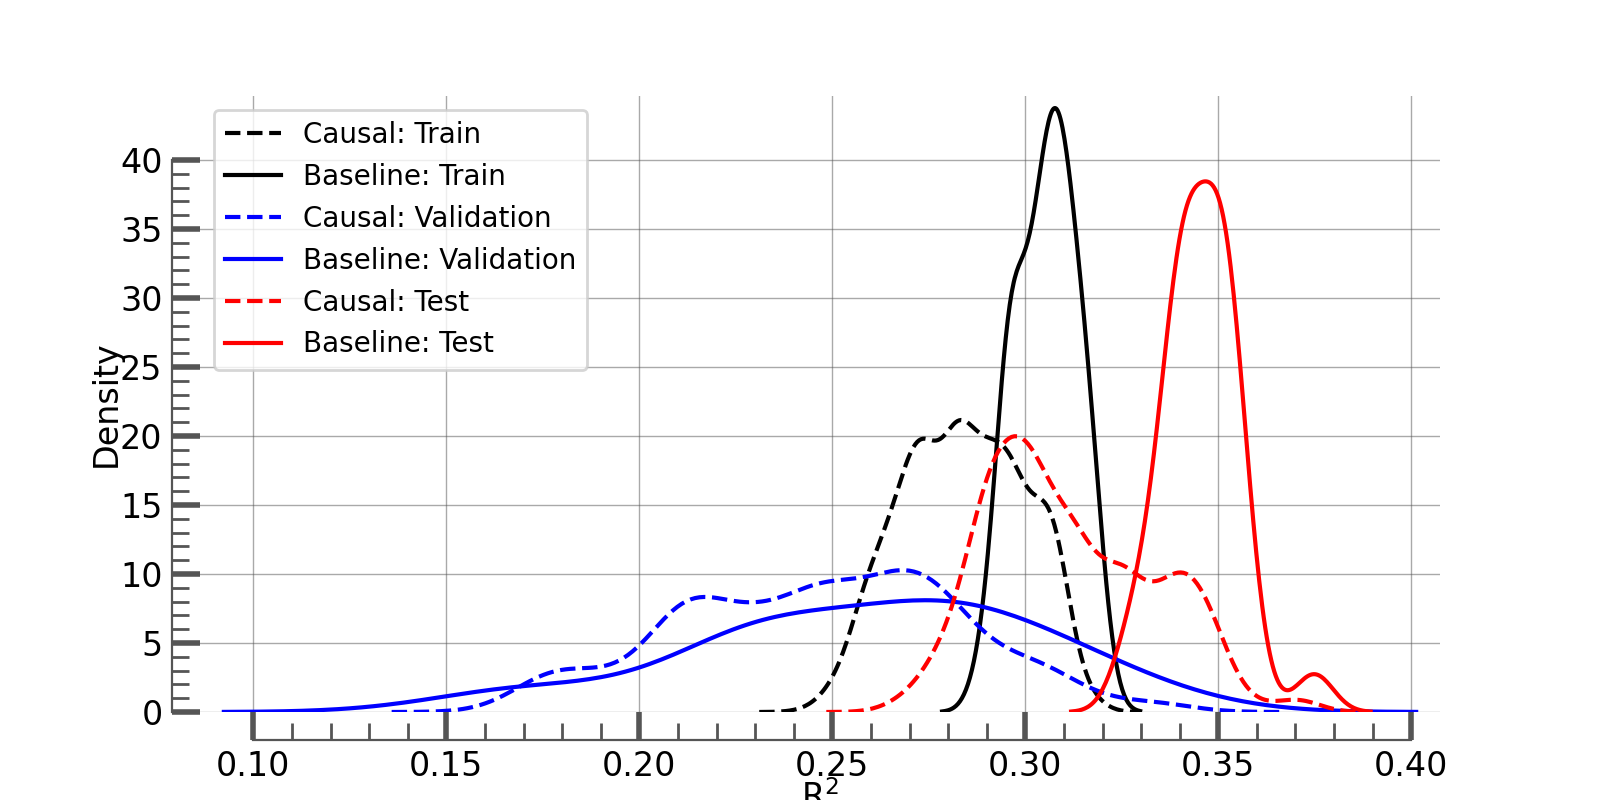

In [105]:
with load_theme("scientific"):
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    sns.kdeplot(miss.flatten(r2_train_causalFS),ls='--',c='k',label='Causal: Train',ax=ax)
    sns.kdeplot((r2_train_noFS),c='k',ls='-',label='Baseline: Train',ax=ax)
    sns.kdeplot(miss.flatten(r2_valid_causalFS),ls='--',c='b',label='Causal: Validation',ax=ax)
    sns.kdeplot((r2_valid_noFS),c='b',ls='-',label='Baseline: Validation',ax=ax)
    sns.kdeplot(miss.flatten(r2_test_causalFS),ls='--',c='r',label='Causal: Test',ax=ax)
    sns.kdeplot((r2_test_noFS),c='r',ls='-',label='Baseline: Test',ax=ax)
    plt.legend(loc=2)
    plt.xlabel('R$^2$')
plt.savefig('./figures/SHIPSonly_r2.png',dpi=600)
plt.show()